In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

import sys
sys.path.append('..')

from helpers import utils, pipelines, models

from sklearn.model_selection import train_test_split

import multiprocessing

from data_augmentaion.data_augmentator import DataAugmentor 

import json

import time

pd.set_option('display.max_columns', None)

### Define research parameters

In [3]:
regression_task = False
continuous_features = ['age', 'fnlwgt', 'hours-per-week']
# metric = 'f1'
metrics = ['f1', 'accuracy', 'precision', 'recall', 'roc_auc']
test_size_proportion = 0.10
augment_sample = 0.5
sample_frac = 0.05

search_pipelines = pipelines.get_classification_pipelines()
search_parameters = models.parameters

settings = [
    {'method': 'random'},
    {'method': 'smote'},
    {'method': 'cf_random'},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 1}},
    {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 5, 'diversity_weight': 0.2, 'sparsity_weight': 1}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 1}},
#     {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 0.2}},
#     {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 1}},
]

### Read and preprocess data

In [4]:
raw_data = pd.read_csv("../datasets/adult.csv")
df = utils.preprocess_adult(raw_data)
target = 'income'

#### split data

In [5]:
# all data
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_proportion, random_state=42)

# sampled data
df_sample = df.sample(frac=sample_frac, random_state=42)
X_sample = df_sample.drop(target, axis=1)
y_sample = df_sample[target]
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample, y_sample, test_size=test_size_proportion, random_state=42)

In [6]:
display(y_train.value_counts())
display(y_sample_train.value_counts())
print(f'y_train classes gap: {y_sample_train.value_counts().max()-y_sample_train.value_counts().min()}')

0    30553
1    10104
Name: income, dtype: int64

0    1523
1     510
Name: income, dtype: int64

y_train classes gap: 1013


In [7]:
full_results_df = pd.DataFrame()

### Whole dataset scores

In [8]:
print(f'whole adult dataset scores:')
_, whole_scores = utils.fit_and_evaluate(X_train, y_train, X_test, y_test,
                    search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
whole_dataset_result_df = pd.DataFrame.from_dict(whole_scores, orient='index')
whole_dataset_result_df.columns = pd.MultiIndex.from_product([['whole']] + [whole_dataset_result_df.columns])
display(whole_dataset_result_df)

whole adult dataset scores:


/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Librar

whole                                        
           f1  accuracy precision    recall   roc_auc
lg   0.614766  0.830235  0.687144  0.557377  0.884911
rf   0.552147  0.822266  0.774684  0.450820  0.878621
xgb  0.633933  0.833333  0.675052  0.589253  0.889692

### Sampled adult dataset scores

In [9]:
print(f'{sample_frac*100}% sampled adult dataset scores:')
_, sampled_scores = utils.fit_and_evaluate(X_sample_train, y_sample_train, X_sample_test, y_sample_test,
                                           search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
sampled_dataset_result_df = pd.DataFrame.from_dict(sampled_scores, orient='index')
sampled_dataset_result_df.columns = pd.MultiIndex.from_product([['sample']] + [sampled_dataset_result_df.columns])
sampled_dataset_result_df

5.0% sampled adult dataset scores:


/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Librar

sample                                        
           f1  accuracy precision    recall   roc_auc
lg   0.543478  0.827434  0.631579  0.510204  0.822553
rf   0.366197  0.805310  0.625000  0.265306  0.827280
xgb  0.527473  0.809735  0.571429  0.489796  0.821400

In [10]:
full_results_df = pd.concat([full_results_df, whole_dataset_result_df, sampled_dataset_result_df], axis=1)

### running experiments

In [11]:
best_estimators = {}
best_scores = {}
total_time = time.time()
for i, s in enumerate(settings):
    start = time.time()
    print(f'{i+1} / {len(settings)}, {s}', end=' ')
    augmentor = DataAugmentor(X_sample_train, y_sample_train, X_sample_test, y_sample_test,
                             method=s['method'], regression=regression_task,
                             continuous_feats=continuous_features,
                             kw_args=s.get('kw_args', {})
                             )

    X_train_augmented_balanced, y_train_augmented_balanced = augmentor.augment(balance=True)
    best_estimators[f'{i}_balanced'], best_scores[f'{i}_balanced'] = \
    utils.fit_and_evaluate(X_train_augmented_balanced, y_train_augmented_balanced, X_sample_test, y_sample_test,
                            search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df_balanced = pd.DataFrame.from_dict(best_scores[f'{i}_balanced'], orient='index')
    result_df_balanced.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])} balanced']] + [result_df_balanced.columns])
    # result_df_balanced.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))} balanced']] + [result_df_balanced.columns])


    X_train_augmented, y_train_augmented = augmentor.augment(balance=False, size=augment_sample)
    best_estimators[f'{i}'], best_scores[f'{i}'] = \
        utils.fit_and_evaluate(X_train_augmented, y_train_augmented, X_sample_test, y_sample_test,
                               search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df = pd.DataFrame.from_dict(best_scores[f'{i}'], orient='index')
    result_df.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])}']] + [result_df.columns])
    # result_df.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))}']] + [result_df.columns])

    full_results_df = pd.concat([full_results_df, result_df_balanced, result_df], axis=1)
    print(f'{time.time() - start} seconds for settings {i}')

print(f'\nTotal time: {time.time() - total_time}')

/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Librar

1 / 4, {'method': 'random'} 

/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Librar

6.3051300048828125 seconds for settings 0
2 / 4, {'method': 'smote'} 

/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/

6.155351877212524 seconds for settings 1
3 / 4, {'method': 'cf_random'} 

/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Librar

model for cf f1 score: {'cf': {'f1': 0.5217391304347826}}
0/1013


100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


50/1013


100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


100/1013


100%|██████████| 1/1 [00:00<00:00, 14.59it/s]


150/1013


100%|██████████| 1/1 [00:00<00:00, 21.96it/s]


200/1013


100%|██████████| 1/1 [00:00<00:00, 22.25it/s]


250/1013


100%|██████████| 1/1 [00:00<00:00, 21.78it/s]


300/1013


100%|██████████| 1/1 [00:00<00:00, 22.61it/s]


350/1013


100%|██████████| 1/1 [00:00<00:00, 14.27it/s]


400/1013


100%|██████████| 1/1 [00:00<00:00, 22.34it/s]


450/1013


100%|██████████| 1/1 [00:00<00:00, 22.42it/s]


500/1013


100%|██████████| 1/1 [00:00<00:00, 22.83it/s]


550/1013


100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


600/1013


100%|██████████| 1/1 [00:00<00:00, 21.83it/s]


650/1013


100%|██████████| 1/1 [00:00<00:00, 21.94it/s]


700/1013


100%|██████████| 1/1 [00:00<00:00, 22.07it/s]


750/1013


100%|██████████| 1/1 [00:00<00:00, 23.21it/s]


800/1013


100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


850/1013


100%|██████████| 1/1 [00:00<00:00, 22.41it/s]


900/1013


100%|██████████| 1/1 [00:00<00:00, 22.10it/s]


950/1013


100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


1000/1013


100%|██████████| 1/1 [00:00<00:00, 17.55it/s]
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all z

model for cf f1 score: {'cf': {'f1': 0.5217391304347826}}
0/1016


100%|██████████| 1/1 [00:00<00:00, 22.08it/s]


50/1016


100%|██████████| 1/1 [00:00<00:00, 22.37it/s]


100/1016


100%|██████████| 1/1 [00:00<00:00, 22.07it/s]


150/1016


100%|██████████| 1/1 [00:00<00:00, 22.02it/s]


200/1016


100%|██████████| 1/1 [00:00<00:00, 21.78it/s]


250/1016


100%|██████████| 1/1 [00:00<00:00, 22.74it/s]


300/1016


100%|██████████| 1/1 [00:00<00:00, 21.38it/s]


350/1016


100%|██████████| 1/1 [00:00<00:00, 21.96it/s]


400/1016


100%|██████████| 1/1 [00:00<00:00, 21.06it/s]


450/1016


100%|██████████| 1/1 [00:00<00:00, 22.02it/s]


500/1016


100%|██████████| 1/1 [00:00<00:00, 22.38it/s]


550/1016


100%|██████████| 1/1 [00:00<00:00, 22.04it/s]


600/1016


100%|██████████| 1/1 [00:00<00:00, 22.73it/s]


650/1016


100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


700/1016


100%|██████████| 1/1 [00:00<00:00, 22.03it/s]


750/1016


100%|██████████| 1/1 [00:00<00:00, 21.79it/s]


800/1016


100%|██████████| 1/1 [00:00<00:00, 21.60it/s]


850/1016


100%|██████████| 1/1 [00:00<00:00, 22.02it/s]


900/1016


100%|██████████| 1/1 [00:00<00:00, 22.10it/s]


950/1016


100%|██████████| 1/1 [00:00<00:00, 22.08it/s]


1000/1016


100%|██████████| 1/1 [00:00<00:00, 21.75it/s]
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all z

257.2945349216461 seconds for settings 2
4 / 4, {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 0.2}} 

/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Librar

model for cf f1 score: {'cf': {'f1': 0.5217391304347826}}
0/1013


100%|██████████| 1/1 [00:00<00:00,  9.93it/s]


50/1013


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


100/1013


100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


150/1013


100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


200/1013


100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


250/1013


100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


300/1013


100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


350/1013


100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


400/1013


100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


450/1013


100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


500/1013


100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


550/1013


100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


600/1013


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


650/1013


100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


700/1013


100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


750/1013


100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


800/1013


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


850/1013


100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


900/1013


100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


950/1013


100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


1000/1013


100%|██████████| 1/1 [00:00<00:00,  9.57it/s]
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 7] during transform. These unknown categories will be encoded

model for cf f1 score: {'cf': {'f1': 0.5217391304347826}}
0/1016


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


50/1016


100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


100/1016


100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


150/1016


100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


200/1016


100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


250/1016


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


300/1016


100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


350/1016


100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


400/1016


100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


450/1016


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


500/1016


100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


550/1016


100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


600/1016


100%|██████████| 1/1 [00:00<00:00,  9.81it/s]


650/1016


100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


700/1016


100%|██████████| 1/1 [00:00<00:00,  9.89it/s]


750/1016


100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


800/1016


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


850/1016


100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


900/1016


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


950/1016


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


1000/1016


100%|██████████| 1/1 [00:00<00:00, 10.22it/s]
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all z

353.59477376937866 seconds for settings 3

Total time: 623.3502941131592


/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/pelegshefi/Librar

### Results

In [12]:
full_results_df

whole                                            sample            \
           f1  accuracy precision    recall   roc_auc        f1  accuracy   
lg   0.614766  0.830235  0.687144  0.557377  0.884911  0.543478  0.827434   
rf   0.552147  0.822266  0.774684  0.450820  0.878621  0.366197  0.805310   
xgb  0.633933  0.833333  0.675052  0.589253  0.889692  0.527473  0.809735   

                                  random balanced                      \
    precision    recall   roc_auc              f1  accuracy precision   
lg   0.631579  0.510204  0.822553        0.552846  0.756637  0.459459   
rf   0.625000  0.265306  0.827280        0.565517  0.721239  0.427083   
xgb  0.571429  0.489796  0.821400        0.512397  0.738938  0.430556   

                           random                                          \
       recall   roc_auc        f1  accuracy precision    recall   roc_auc   
lg   0.714286  0.820362  0.537634  0.809735  0.615385  0.510204  0.818171   
rf   0.836735  0.830278  0.416667  0.814159  0.588235  0.306122  0.830393   
xgb  0.612245  0.813098  0.479167  0.778761  0.489362  0.489796  0.815865   

    smote balanced                                             smote  \
                f1  accuracy precision    recall   roc_auc        f1   
lg        0.521739  0.756637  0.454545  0.632653  0.805834  0.521739   
rf        0.529412  0.730088  0.428571  0.734694  0.812925  0.529412   
xgb       0.517857  0.756637  0.426230  0.591837  0.802375  0.517857   

                                            cf_random balanced            \
     accuracy precision    recall   roc_auc                 f1  accuracy   
lg   0.756637  0.454545  0.632653  0.805834           0.523364  0.774336   
rf   0.730088  0.428571  0.734694  0.812925           0.557823  0.747788   
xgb  0.756637  0.426230  0.591837  0.802375           0.464286  0.756637   

                                  cf_random                                \
    precision    recall   roc_auc        f1  accuracy precision    recall   
lg   0.482759  0.612245  0.796956  0.545455  0.769912  0.473684  0.612245   
rf   0.444444  0.836735  0.827280  0.569444  0.725664  0.456790  0.857143   
xgb  0.451613  0.530612  0.803874  0.529915  0.756637  0.455882  0.612245   

              cf_genetic balanced                                          \
      roc_auc                  f1  accuracy precision    recall   roc_auc   
lg   0.797071            0.573913  0.783186  0.500000  0.673469  0.808256   
rf   0.831085            0.546763  0.721239  0.422222  0.795918  0.822899   
xgb  0.807910            0.540541  0.769912  0.483871  0.693878  0.811945   

    cf_genetic                                          
            f1  accuracy precision    recall   roc_auc  
lg    0.573913  0.783186  0.500000  0.673469  0.806526  
rf    0.562963  0.738938  0.441860  0.775510  0.822207  
xgb   0.553571  0.778761  0.492063  0.632653  0.813329

In [13]:
print('best methods')
best_methods = pd.DataFrame()
for s in metrics:
    models_scores = full_results_df.xs(s, axis='columns', level=1)
    max_models = models_scores.idxmax(axis='columns')
    max_models.name = s
    max_models['overall'] = models_scores.max(axis=0).idxmax(axis=0)
    best_methods = pd.concat([best_methods, max_models], axis=1)
best_methods

best methods


,f1,accuracy,precision,recall,roc_auc
lg,whole,whole,whole,random balanced,whole
rf,cf_random,whole,whole,cf_random,whole
xgb,whole,whole,whole,cf_genetic balanced,whole
overall,whole,whole,whole,cf_random,whole


In [14]:
full_results_df.to_csv(rf'../log/experiment_classification_adult_testsize{test_size_proportion}_augmentsample{augment_sample}.csv')

In [15]:
print('Methods and their scores')
methods_scores = {}
for s in metrics:
    models_scores = full_results_df.xs(s, axis='columns', level=1)
    methods_scores[s] = models_scores

Methods and their scores


In [21]:
float_format = "{:0.4f}".format
for metric, df in methods_scores.items():
    latex = df.to_latex(float_format=float_format, index=False)
    latex = latex.replace('\\toprule', '').replace('\\midrule', '').replace('\\bottomrule', '')
    latex = latex.split('\n')
    latex.insert(1, '\\toprule')
    latex.insert(4, '\\midrule')
    latex.insert(-1, '\\bottomrule')
    latex = '\n'.join(latex)

    
    # Write the LaTeX table to a file
    with open(f'../graphs/adult/latex/adult_{metric}_table.tex', 'w') as f:
        f.write(latex)

/var/folders/vk/hzbp84pd4xj2yyb43dry8k340000gn/T/ipykernel_77150/2287231928.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df.to_latex(float_format=float_format, index=False)


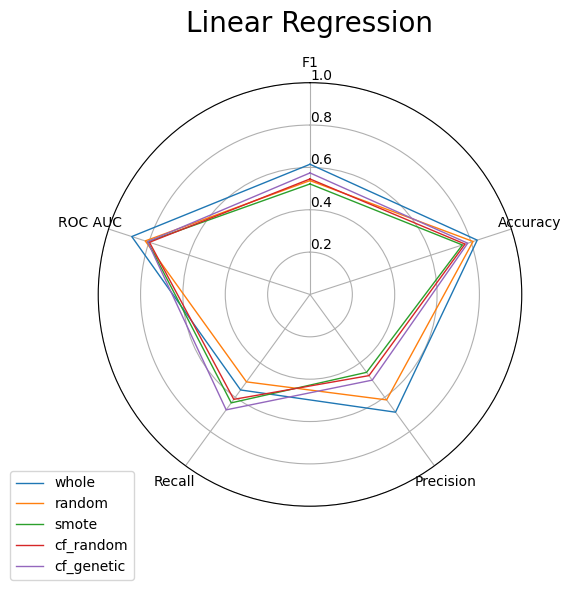

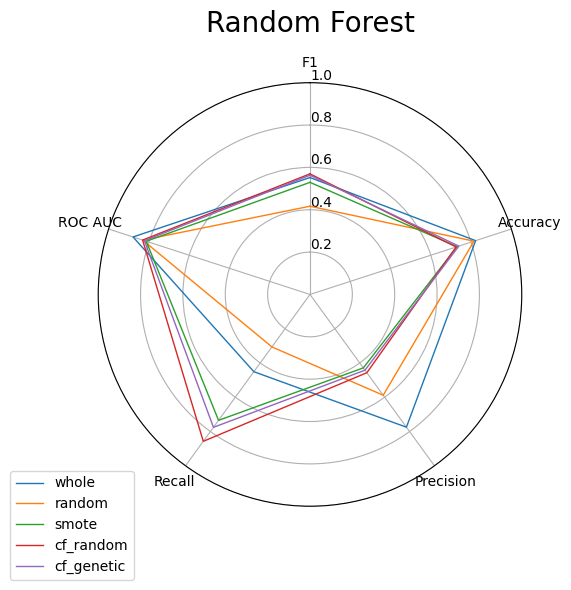

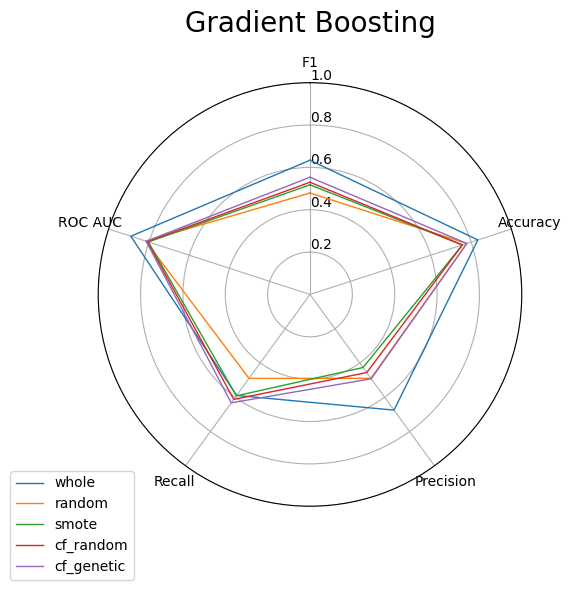

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the list of models
models = list(next(iter(methods_scores.values())).index)
# Number of variables (i.e., number of metrics)
wanted_cols = ['whole', 'random','smote','cf_random','cf_genetic']
metric_names = ['F1', 'Accuracy', 'Precision', 'Recall','ROC AUC']  

num_vars = len(methods_scores)

# Compute angle of each axis in the plot (divide the plot / number of variable)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Ensure the plot is a full circle
angles += angles[:1]
def plot_spider(df, idx=0, title='Spider plot'):
    # Initialise the spider plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Makes sure the First metric is at the top
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], metric_names)
    ax.set_rlabel_position(0)
    plt.ylim(0, 1)
    # print(df.iloc[0])
    values = []
    labels = df.columns
    for _, df in methods_scores.items(): 
        df2 = df[wanted_cols]
        values.append(df2.iloc[idx])
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=wanted_cols)
    # ax.fill(angles,values, alpha=0.1)


    # Add legend
    plt.title(title, size=20, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'../graphs/adult/{title}.png')

plot_spider(df, idx=0, title='Linear Regression')
plot_spider(df, idx=1, title='Random Forest')
plot_spider(df, idx=2, title='Gradient Boosting')